# Lab9

In [94]:
from typing import Dict, List, Tuple, Optional
from collections import namedtuple
import os

from functional import seq, pseq
from functional.streams import Sequence

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import xml.etree.ElementTree
from xml.etree.ElementTree import Element

import functools

def compose(*functions):
    def compose2(f, g):
        return lambda x: f(g(x))
    return functools.reduce(compose2, functions, lambda x: x)

from datetime import datetime
def hour_str():
    return str(datetime.now()).split(".")[0].split(" ")[-1]

from IPython.core.display import HTML
def display_seq(sequence:Sequence,rows:int)-> None:
        sequence._repr_html_= lambda :sequence.tabulate(rows,tablefmt='html')
        display(sequence)
        sequence._repr_html_= lambda :sequence.tabulate(10,tablefmt='html')


In [2]:
ustawy_dir = "../ustawy"
cll_dir = "../cll"

In [3]:
filenames = os.listdir(ustawy_dir)

In [4]:
chosen_ones = np.random.choice(filenames,size=100,replace= False)

# Clarin Api

In [5]:
base_url = "https://ws.clarin-pl.eu/nlprest2/"
process_url = base_url+ "base/process"
ids_file = "ids.bak"

In [6]:
import requests as r

## Prepare clls

In [7]:
def process_body(text: str):
    return \
        {"lpmn": "any2txt|wcrft2|liner2({\"model\":\"n82\"})",
         "text": text,
         "user": "moj@adres.mail"
         }

### Async api

In [8]:
def start_task(text:str)-> str:
    response = r.post(url=base_url + "base/startTask", json=process_body(text))
    return response.content.decode("utf-8")

In [9]:
def task_status(task_id:str)-> str:
    response = r.get(url=base_url + "base/getStatus/{}".format(task_id)).json()
    return response

def is_task_done(status):
    return status["status"] == "DONE"

def get_file_id(status):
    return status["value"][0]["fileID"]

In [10]:
def download_task_result(file_id:str)-> str:
    response = r.get(url=base_url + "base/download{}".format(file_id))
    return response.content.decode("utf-8")

#### Group functions

In [11]:
def str_from_file(fn):
    file = open(fn,"r")
    res = file.read()
    file.close()
    return res

In [12]:
def submit_saving_id_to_file(filenames:List[str]):
    id_file = open(ids_file,"w")
    seq(filenames)\
    .map(lambda fn: f"{ustawy_dir}/{fn}")\
    .map(lambda fn: id_file.write(start_task(str_from_file(fn)) + "\n"))\
    .for_each(lambda x: id_file.flush())
    id_file.close()

In [101]:
raise Exception# to avoid executing
submit_saving_id_to_file(chosen_ones)

In [14]:
!wc -l ids.bak

     100 ids.bak


In [15]:
def get_statuses(limit:Optional[int]= None)-> Sequence:
    file = open(ids_file,"r")
    l = 1000 if limit is None else limit
    
    task_ids = pseq(file.readlines()[:l]).map(lambda x : x.replace("\n",""))
    file.close()
    return task_ids.map(task_status)

def done_percentage(statuses:Sequence):
    return statuses.count(is_task_done) *1.0/ statuses.size()

In [102]:
raise Exception
statuses = get_statuses()

In [103]:
done_percentage(statuses)

In [104]:
file_ids= statuses.map(get_file_id)

In [19]:
def get_and_save_cll(file_id:str,count:int):
    print(f"Downloading {count}")
    try:
        txt = download_task_result(file_id)
        fn = file_id.split("/")[-1]
        file = open(f'{cll_dir}/{fn}',"w")
        file.write(txt)
        file.close()
    except:
        print(f"Failed donwloading {file_id},")
        get_and_save_cll(file_id,count)

In [20]:
! mkdir  "../cll"

mkdir: ../cll: File exists


Save clls:

In [ ]:
raise Exception
file_ids.enumerate().for_each(lambda i_file_id: get_and_save_cll(i_file_id[1],i_file_id[1]))

### Sync Api
> Not used, but helpful for debugging

In [21]:
def cll_from_text(text:str)-> str:
    response = r.post(url=process_url, json=process_body(text))
    return response.content.decode("utf-8")

In [22]:
def rewrite_as_cll(base_dir:str,filename:str,cll_dir:str,retry_count:int = 0)-> None:
    file = open(base_dir + "/" + filename ,"r")
    text = file.read()
    file.close()
    try:
        print("Retrieving cll for {}.  {}".format(filename,hour_str()))
        cll = cll_from_text(text)
        write_file = open(cll_dir + "/" + filename ,"w")
        write_file.write(cll)
        write_file.close()
    except FileNotFoundError:
        os.mkdir(cll_dir)
        rewrite_as_cll(base_dir,filename,cll_dir)
    except Exception:
        print("Retrieving cll for {} failed, retrying {} time. {}".format(filename,retry_count,hour_str()))
        rewrite_as_cll(base_dir,filename,cll_dir,retry_count= retry_count+1)

# Parsing CLL

In [23]:
NamedEntity = namedtuple("NamedEntity", "orth lex_base entity")

In [24]:
EntityWord = namedtuple("EntityWord", "orth lex_base entity number")

In [25]:
def get_active_chan_annotation(token:Element)-> Optional[str]:
    return seq(token.findall("ann"))\
    .filter(lambda x : x.text != "0")\
    .map(lambda x: (x.attrib["chan"],x.text))\
    .head_option()

def token_word(element: Element) -> Optional[NamedEntity]:
    annotation = get_active_chan_annotation(element)

    if annotation is None:
        return None
    else:
        chan, value = annotation
        orth = element.findtext("orth")
        lex_base = element.findtext("lex/base")
        return EntityWord(orth=orth, lex_base=lex_base, entity=chan, number=int(value))

In [26]:
def group_to_entity(group:List[EntityWord]) -> NamedEntity:
        orth = seq(group).map(lambda e: e.orth).reduce(lambda x,y: x + " " + y)
        lex_base = seq(group).map(lambda e: e.lex_base).reduce(lambda x,y: x + " " + y)
        
        return NamedEntity(orth=orth,lex_base = lex_base,entity= group[0].entity)

In [27]:
def sentence_to_entities(sentence:Element) -> List[NamedEntity]:
    return seq(sentence.findall("tok"))\
    .map(token_word)\
    .filter_not(lambda x : x is None)\
    .group_by(lambda x : x.entity +str(x.number))\
    .map(lambda g: group_to_entity(g[1])).to_list()

In [28]:
def tokens_from_cll(cll:str)-> Sequence:
    e = xml.etree.ElementTree.fromstring(cll)
    sentences = e.findall("chunk/sentence")
    return seq(sentences).flat_map(sentence_to_entities)

In [29]:
def tokens_from_cll_file(fn:str) -> Sequence:
    file = open(cll_dir + "/" + fn ,"r")
    res = tokens_from_cll(file.read())
    file.close()
    return res

## Actual Parsing 

In [58]:
clls = os.listdir(cll_dir)
clls[:10]

['f74d130b-16f5-4bf8-8706-f9a4f5c617ec',
 '42eae721-64b1-4067-80fb-c00907b98f7e',
 '7675fefc-8942-4109-a8e3-ac5ee66b8bba',
 '8fbff38b-07d5-4acc-84a4-ee1c2bf48b45',
 '27db18c5-3ecd-4024-8f2e-a53f7fa6d018',
 '3ea10ddd-8f2d-4baa-afb8-5642d4899ef3',
 '749a10bf-63ea-411e-b973-4dd912ee3265',
 '6da332bc-a453-43db-a078-707de6de344d',
 '01266d2c-c5d1-44c1-9339-93e10713f0ce',
 'ae8940ab-b131-4026-98fb-26d933d803bd']

In [59]:
cll = tokens_from_cll_file(clls[0])
cll

orth,lex_base,entity
Dz . U .,Dzieje_(Apostolskie) . u .,nam_pro_media_periodic
ustawie z dnia 21 marca 1985 r . o drogach publicznych,ustawa z dzień 21 marzec 1985 r . o droga publiczny,nam_pro_title_document
Dz . U .,Dzieje_(Apostolskie) . u .,nam_pro_media_periodic
Gospodarki Morskiej,gospodarka morski,nam_liv_person


In [60]:
NerOccurrences = namedtuple("NerOccurrences", "lex_base fine coarse count")

In [61]:
def ner_group_to_ner_ocurrences(group: Tuple[int, List[NamedEntity]]) -> NerOccurrences:
    head = group[1][0]
    return NerOccurrences(
        lex_base=head.lex_base,
        fine=head.entity,
        coarse="_".join(head.entity.split("_")[:2]),
        count =len(group[1])
    )

In [62]:
ner_ocurrences = seq(clls)\
    .flat_map(tokens_from_cll_file)\
    .group_by(lambda x: x.entity)\
    .flat_map(lambda g:
        seq(g[1])\
         .group_by(lambda ner: ner.lex_base)\
         .map(ner_group_to_ner_ocurrences)
        
    )

In [63]:
ner_ocurrences.size()

1360

In [64]:
ner_ocurrences.to_csv("ners.bak")

In [65]:
ner_ocurrences[0]

NerOccurrences(lex_base='Dzieje_(Apostolskie) . u .', fine='nam_pro_media_periodic', coarse='nam_pro', count=754)

# Analysis

1. Plot the frequency of the recognized classes:

   a) fine-grained classification histogram (classes such as nam_fac_bridge, nam_liv_animal).
   
   b) coarse-grained classification histogram (classes such as nam_adj, nam_eve, nam_fac).



In [81]:
def plot_historgram(data:Sequence,title:str):

    freq_series = pd.Series(data.map(lambda x: x[1]).to_list())

    x_labels = data.map(lambda x:x[0]).to_list()

    # Plot the figure.
    plt.figure(figsize=(20, 8))
    ax = freq_series.plot(kind='bar')
    ax.set_title(title)
    ax.set_xlabel('Categories')
    ax.set_ylabel('Occurrences')
    ax.set_xticklabels(x_labels)

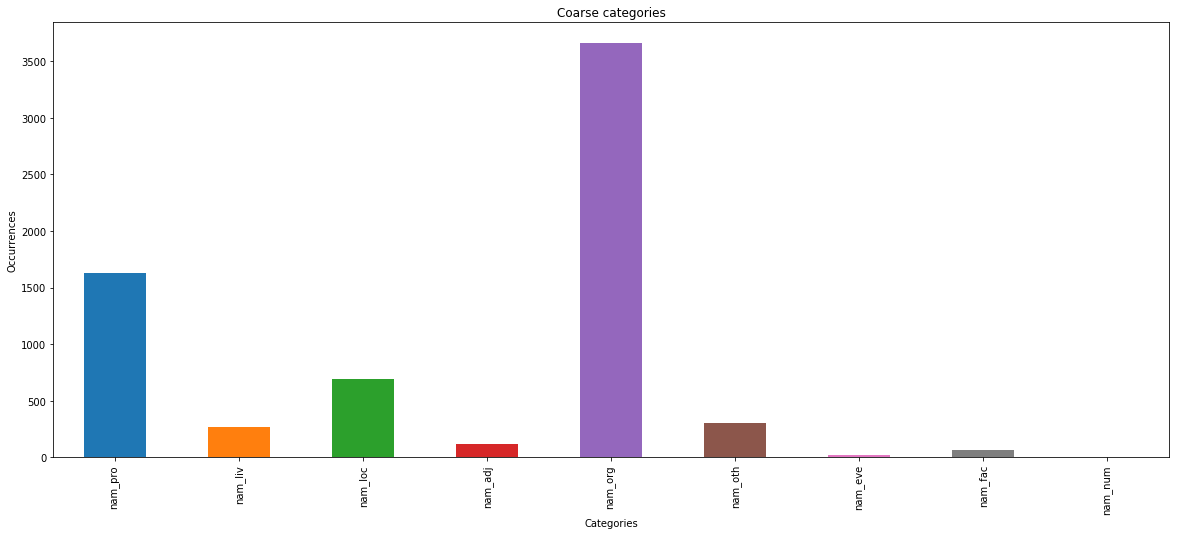

In [85]:
coarse = ner_ocurrences.group_by(lambda x: x.coarse).map(lambda g:(g[0],seq(g[1]).map(lambda x: x.count).sum()))
plot_historgram(coarse,"Coarse categories")

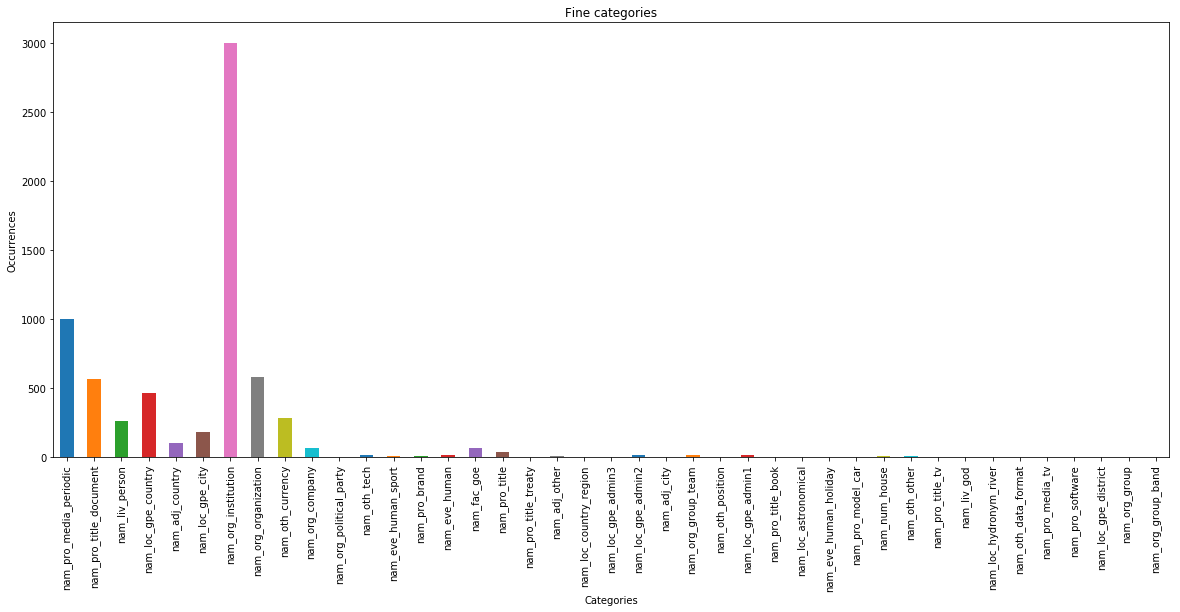

In [100]:
fine = ner_ocurrences.group_by(lambda x: x.fine).map(lambda g:(g[0],seq(g[1]).map(lambda x: x.count).sum()))
plot_historgram(fine,"Fine categories")

2\. Display 50 most frequent Named Entities including their count and fine-grained type.


In [91]:
display_seq(ner_ocurrences.order_by(lambda x: - x.count),50)

lex_base,fine,coarse,count
Dzieje_(Apostolskie) . u .,nam_pro_media_periodic,nam_pro,754
rzeczpospolita polski,nam_loc_gpe_country,nam_loc,358
złoty,nam_oth_currency,nam_oth,239
dziennik . u .,nam_pro_media_periodic,nam_pro,192
skarb państwo,nam_org_institution,nam_org,188
minister obrona narodowy,nam_org_institution,nam_org,136
rada minister,nam_org_institution,nam_org,135
prezes rad minister,nam_org_institution,nam_org,122
unia europejski,nam_org_organization,nam_org,101
polski,nam_adj_country,nam_adj,95


3\. Display 10 most frequent Named Entities for each coarse-grained type.

In [99]:
for group, entries in ner_ocurrences.group_by(lambda neo: neo.coarse):
    display(HTML(f"<h1>{group}</h1>"))
    display_seq(seq(entries).order_by(lambda x: - x.count),10)

lex_base,fine,coarse,count
Dzieje_(Apostolskie) . u .,nam_pro_media_periodic,nam_pro,754
dziennik . u .,nam_pro_media_periodic,nam_pro,192
kodeks karny,nam_pro_title_document,nam_pro,25
kodeks postępowanie cywilny,nam_pro_title_document,nam_pro,19
kodeks postępowanie administracyjny,nam_pro_title_document,nam_pro,19
kodeks karny skarbowy,nam_pro_title_document,nam_pro,19
dziennik . URz,nam_pro_media_periodic,nam_pro,13
kodeks postępowanie karny,nam_pro_title_document,nam_pro,13
kodeks cywilny,nam_pro_title_document,nam_pro,12
dziennik urzędowy,nam_pro_media_periodic,nam_pro,10


lex_base,fine,coarse,count
generalny inspektor,nam_liv_person,nam_liv,22
główny inspektor,nam_liv_person,nam_liv,17
sekunda T a w a,nam_liv_person,nam_liv,16
Art,nam_liv_person,nam_liv,13
siła zbrojny,nam_liv_person,nam_liv,9
rzecznik ubezpieczona,nam_liv_person,nam_liv,9
Marek Kuchciński,nam_liv_person,nam_liv,8
kart nauczyciel,nam_liv_person,nam_liv,7
główny lekarz weterynaria,nam_liv_person,nam_liv,7
żandarmeria wojskowy,nam_liv_person,nam_liv,7


lex_base,fine,coarse,count
rzeczpospolita polski,nam_loc_gpe_country,nam_loc,358
Warszawa,nam_loc_gpe_city,nam_loc,48
Rzeczpospolita Polska,nam_loc_gpe_country,nam_loc,39
Polska,nam_loc_gpe_country,nam_loc,38
rejestr,nam_loc_gpe_city,nam_loc,20
warszawski,nam_loc_gpe_admin2,nam_loc,8
konfederacja szwajcarski,nam_loc_gpe_country,nam_loc,5
USA,nam_loc_gpe_country,nam_loc,5
rad,nam_loc_gpe_city,nam_loc,5
Oświęcim,nam_loc_gpe_city,nam_loc,5


lex_base,fine,coarse,count
polski,nam_adj_country,nam_adj,95
wojewódzki,nam_adj_country,nam_adj,5
europejski,nam_adj_other,nam_adj,3
afrykański,nam_adj_country,nam_adj,2
mazowiecki,nam_adj_other,nam_adj,2
warszawski,nam_adj_city,nam_adj,2
macierzyński,nam_adj_country,nam_adj,1
łowiecki,nam_adj_country,nam_adj,1
unijny,nam_adj_other,nam_adj,1
audytorski,nam_adj_other,nam_adj,1


lex_base,fine,coarse,count
skarb państwo,nam_org_institution,nam_org,188
minister obrona narodowy,nam_org_institution,nam_org,136
rada minister,nam_org_institution,nam_org,135
prezes rad minister,nam_org_institution,nam_org,122
unia europejski,nam_org_organization,nam_org,101
minister finanse,nam_org_institution,nam_org,92
minister sprawiedliwość,nam_org_institution,nam_org,90
państwowy straż pożarny,nam_org_organization,nam_org,83
żandarmeria wojskowy,nam_org_institution,nam_org,61
agencja,nam_org_institution,nam_org,57


lex_base,fine,coarse,count
złoty,nam_oth_currency,nam_oth,239
euro,nam_oth_currency,nam_oth,33
ECU,nam_oth_currency,nam_oth,6
PKD,nam_oth_tech,nam_oth,5
dolar,nam_oth_currency,nam_oth,3
PESEL,nam_oth_tech,nam_oth,3
minister edukacja narodowy,nam_oth_position,nam_oth,3
C - D,nam_oth_tech,nam_oth,2
4 . 1 .,nam_oth_other,nam_oth,2
pomidor,nam_oth_currency,nam_oth,1


lex_base,fine,coarse,count
żandarmeria wojskowy,nam_eve_human,nam_eve,4
siła zbrojny,nam_eve_human_holiday,nam_eve,2
monitor sądowy,nam_eve_human_sport,nam_eve,1
polski norma PN,nam_eve_human_sport,nam_eve,1
euro,nam_eve_human_sport,nam_eve,1
mistrzostwa Europa w piłka nożny UEFA euro 2012,nam_eve_human_sport,nam_eve,1
mistrzostwa Europa w piłka nożny UEFA,nam_eve_human_sport,nam_eve,1
euro 2012,nam_eve_human_sport,nam_eve,1
krajowy rejestr sądowy,nam_eve_human,nam_eve,1
generalny konserwator zabytek,nam_eve_human,nam_eve,1


lex_base,fine,coarse,count
komendant główny,nam_fac_goe,nam_fac,16
pomnik zagłada,nam_fac_goe,nam_fac,14
krajowy rejestr sądowy,nam_fac_goe,nam_fac,9
straż graniczny,nam_fac_goe,nam_fac,3
centralne muzeum pożarnictwo,nam_fac_goe,nam_fac,2
"muzeum "" Stutthof",nam_fac_goe,nam_fac,2
muzeum pożarnictwo,nam_fac_goe,nam_fac,1
kościół ewangelicko - metodystyczny,nam_fac_goe,nam_fac,1
kościół adwentysta dzień siódmy,nam_fac_goe,nam_fac,1
krajowy rejestr karny,nam_fac_goe,nam_fac,1


lex_base,fine,coarse,count
1,nam_num_house,nam_num,7


4\. Discuss the results of the extraction.

1. Funny thing happened: Dz.U (or sth similar) Was often lemmatized to Dzieje Apostolskie
2. Rzeczposopolita polska appeared twice in ranking. This might be my fault - I took first lemma of a wod from CLL.
3. Words in top 50 are not that surprising.
4. No idea why number was considered a named entity.
5. Pomidor is a <span style="color:red">currency </span>
6. **Minister edukacji narodowej** is a position while **prezes rady ministrów** is an institution.
7. Events were recognised poorly.